# 3.3.9 モデル住宅作成結果の感度解析(戸建住宅を含む)

### 必要なモジュールのimport

In [4]:
import os, sys
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

sys.path.append("../experiments")
from common.web_input import create_web_input_from_house_data
from common.house_data import HouseData
from common.utils.func import load_json

### DataFrameを作成

In [5]:
def create_heat_load_dict(
    folder: str,
    index: str,
    model_plan: str,
    main_direction: str,
    region_name: str,
    insulation_level: str,
    structure: str,
) -> dict:
    # 簡易化前(=コントロール群)の暖冷房負荷を取得
    with open(f'{folder}/result_summary_{index}.json', mode='r', encoding='utf-8') as result_json:
        result = json.load(result_json)

    # 簡易化後(=対照群)の暖冷房負荷を取得
    with open(f'{folder}/new_result_summary_{index}.json', mode='r', encoding='utf-8') as result_json_new:
        result_new = json.load(result_json_new)

    # 簡易化前の年間暖房負荷・年間冷房負荷を計算。ただし
    #   * l_s_c_h_sum_MJ: 年間対流空調顕熱負荷(暖房) [MJ]
    #   * l_s_c_c_sum_MJ: 年間対流空調顕熱負荷(冷房) [MJ]
    #   * l_s_r_h_sum_MJ: 年間放射空調顕熱負荷(暖房) [MJ]
    #   * l_s_r_c_sum_MJ: 年間放射空調顕熱負荷(冷房) [MJ]
    #   * l_l_c_h_sum_MJ: 年間対流空調潜熱負荷(暖房) [MJ]
    #   * l_l_c_c_sum_MJ: 年間対流空調潜熱負荷(冷房) [MJ]
    l_h_sum_MJ = result['l_s_c_h_sum_MJ'] + result['l_s_r_h_sum_MJ'] + result['l_l_c_h_sum_MJ']
    l_c_sum_MJ = -(result['l_s_c_c_sum_MJ'] + result['l_s_r_c_sum_MJ'] + result['l_l_c_c_sum_MJ'])

    # 簡易化後の年間暖房負荷・年間冷房負荷を計算。
    l_h_sum_MJ_new = result_new['l_s_c_h_sum_MJ'] + result_new['l_s_r_h_sum_MJ'] + result_new['l_l_c_h_sum_MJ']
    l_c_sum_MJ_new = -(result_new['l_s_c_c_sum_MJ'] + result_new['l_s_r_c_sum_MJ'] + result_new['l_l_c_c_sum_MJ'])

    # 簡易化前の入力JSONから計算した簡易計算条件(≒住宅Webプログラムの画面入力)を取得
    region = {
        '岩見沢': 2,
        '岡山': 6,
        '那覇': 8,
    }[region_name]
    house_data_path = f'{folder}/house_data_{index}.json'
    house_data = load_json(house_data_path, data_class=HouseData)
    web_input = create_web_input_from_house_data(region, house_data)

    # 簡易化後の入力JSONから計算した簡易計算条件(≒住宅Webプログラムの画面入力)を取得
    house_data_path_new = f'{folder}/new_house_data_{index}.json'
    house_data_new = load_json(house_data_path_new, data_class=HouseData)
    web_input_new = create_web_input_from_house_data(region, house_data_new)    

    # 従来の簡易入力方法との比較のため、ηAHとηACを暖冷房期間で案分した値を出力する。
    # (現状の計算方法ではηAH, ηAC両方の値を保証することができないため)
    day_h, day_c = [
        [257, 53],
        [252, 48],
        [244, 53],
        [242, 53],
        [218, 57],
        [169, 117],
        [122, 152],
        [0, 265],
    ][region - 1]
    eta_A = (web_input.eta_A_H * day_h + web_input.eta_A_C * day_c) / (day_h + day_c)
    eta_A_new = (web_input_new.eta_A_H * day_h + web_input_new.eta_A_C * day_c) / (day_h + day_c)

    return {
        '建物モデル': model_plan,
        '主開口方位': main_direction,
        '地域': region_name,
        '断熱仕様': insulation_level,
        '断熱位置': structure,
        '年間暖房負荷(詳細な入力) [GJ]': l_h_sum_MJ / 1000,
        '年間冷房負荷(詳細な入力) [GJ]': l_c_sum_MJ / 1000,
        '年間暖房負荷(実用的な入力) [GJ]': l_h_sum_MJ_new / 1000,
        '年間冷房負荷(実用的な入力) [GJ]': l_c_sum_MJ_new / 1000,
        'U_A(詳細な入力) [W/m2K]': web_input.U_A,
        'eta_AH(詳細な入力) [-]': web_input.eta_A_H,
        'eta_AC(詳細な入力) [-]': web_input.eta_A_C,
        'eta_A(詳細な入力) [-]': eta_A,
        'A_env(詳細な入力)': web_input.A_env,
        'U_A(実用的な入力) [W/m2K]': web_input_new.U_A,
        'eta_AH(実用的な入力) [-]': web_input_new.eta_A_H,
        'eta_AC(実用的な入力) [-]': web_input_new.eta_A_C,
        'eta_A(実用的な入力) [-]': eta_A_new,
        'A_env(実用的な入力)': web_input_new.A_env,
    }

def create_heat_load_df(folder:str) -> pd.DataFrame:
    with open(f'{folder}/index.csv', mode='r', encoding='utf-8', newline='') as index_csv:
        index_csv_reader = csv.reader(index_csv)
        next(index_csv_reader)  # ヘッダ行をスキップ
        heat_load_dicts = [create_heat_load_dict(folder, *_) for _ in index_csv_reader]
    return pd.DataFrame(heat_load_dicts)


heat_load_df = create_heat_load_df('result_kodate')

データフレームを作成し、中身を確認する。

In [9]:
heat_load_df.head()

,建物モデル,主開口方位,地域,断熱仕様,断熱位置,年間暖房負荷(詳細な入力) [GJ],年間冷房負荷(詳細な入力) [GJ],年間暖房負荷(実用的な入力) [GJ],年間冷房負荷(実用的な入力) [GJ],U_A(詳細な入力) [W/m2K],eta_AH(詳細な入力) [-],eta_AC(詳細な入力) [-],eta_A(詳細な入力) [-],A_env(詳細な入力),U_A(実用的な入力) [W/m2K],eta_AH(実用的な入力) [-],eta_AC(実用的な入力) [-],eta_A(実用的な入力) [-],A_env(実用的な入力)
0,戸建2F,南,岡山,H4,床断熱,29.301893,12.545858,26.781600,9.464886,1.457477,3.565117,3.485760,3.532653,292.61235,1.457477,3.436047,3.672195,3.532653,292.61235
1,戸建2F,南,岡山,H4,基礎断熱,25.967028,11.952505,25.533601,10.689795,1.405270,3.771710,3.620795,3.709972,304.98835,1.405270,3.627752,3.828735,3.709972,304.98835
2,戸建2F,南,岡山,H11,床断熱,19.095634,12.191539,15.918323,9.557160,0.857238,2.591804,2.585995,2.589427,292.61235,0.857238,2.496697,2.723371,2.589427,292.61235
3,戸建2F,南,岡山,H11,基礎断熱,17.615428,10.834328,17.855399,9.949469,0.932480,2.837893,2.757541,2.805022,304.98835,0.932480,2.723240,2.923151,2.805022,304.98835
4,戸建2F,南,岡山,H11超,床断熱,15.038020,7.852930,12.194468,6.858511,0.547774,1.434717,1.416324,1.427193,292.61235,0.547774,1.375875,1.501318,1.427193,292.61235


### 年間暖冷房負荷の誤差をプロット

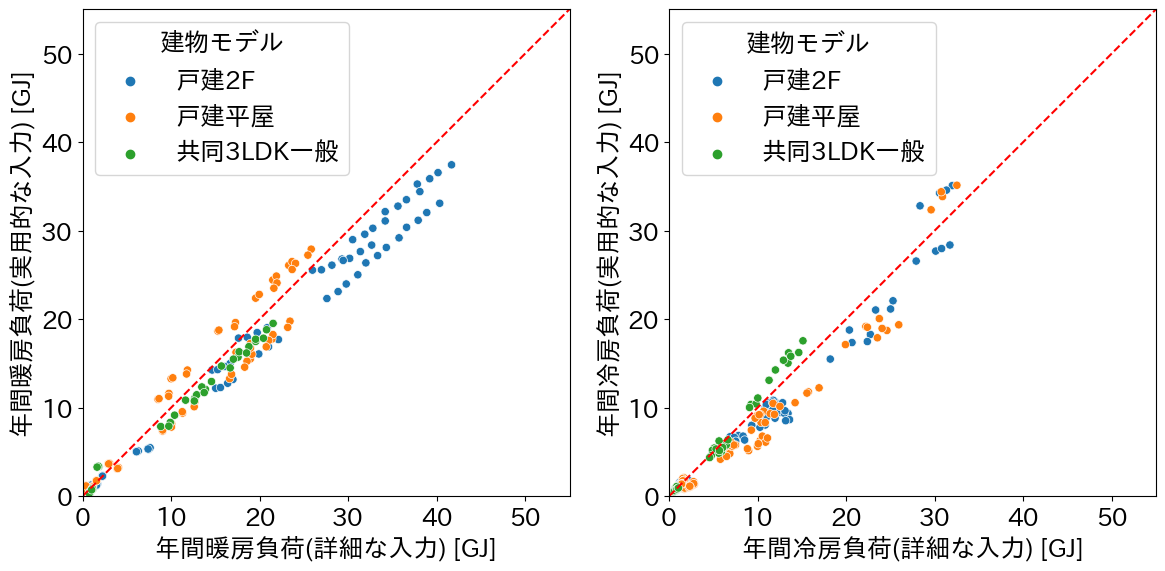

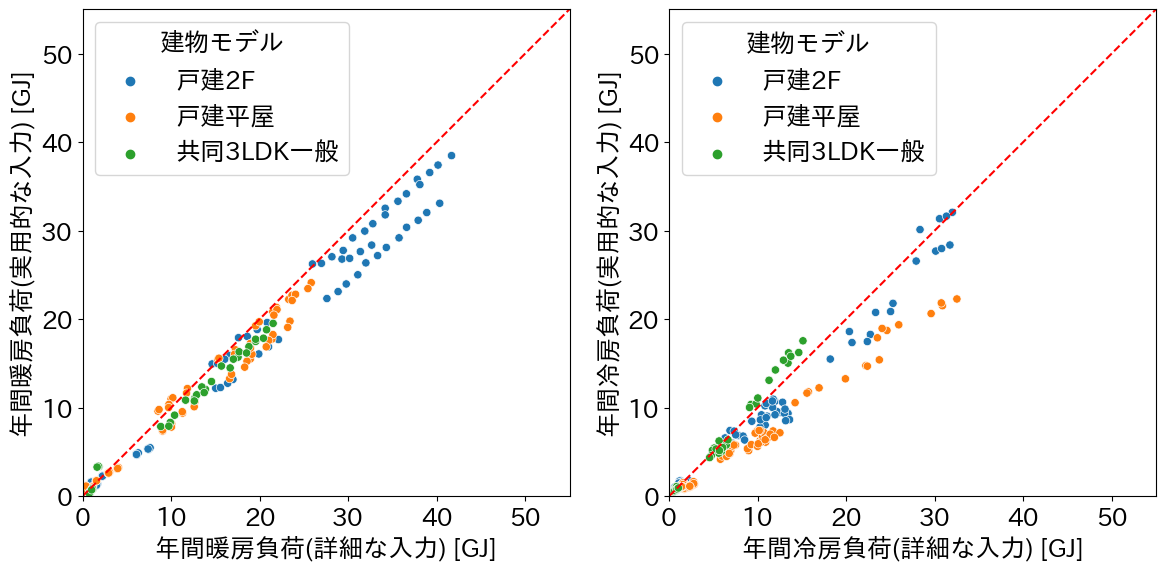

In [7]:
def plot(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    plt.rcParams['font.size'] = 18

    sns.scatterplot(df, x='年間暖房負荷(詳細な入力) [GJ]', y='年間暖房負荷(実用的な入力) [GJ]', hue='建物モデル', ax=axes[0])
    axes[0].set_xlim([0, 55.0])
    axes[0].set_ylim([0, 55.0])
    axes[0].set_aspect('equal')
    axes[0].plot([0, 55.0], [0, 55.0], 'r--')   # X=Y の線を描く

    sns.scatterplot(df, x='年間冷房負荷(詳細な入力) [GJ]', y='年間冷房負荷(実用的な入力) [GJ]', hue='建物モデル', ax=axes[1])
    axes[1].set_xlim([0, 55.0])
    axes[1].set_ylim([0, 55.0])
    axes[1].set_aspect('equal')
    axes[1].plot([0, 55.0], [0, 55.0], 'r--')   # X=Y の線を描く

    plt.tight_layout()

# 戸建住戸における断熱位置を与えた場合
plot(heat_load_df)

# 戸建住戸における断熱位置を与えない場合
plot(create_heat_load_df('result_kodate_yukadannetsu'))

### UA・ηAH・ηAC・ηAの誤差をプロット 

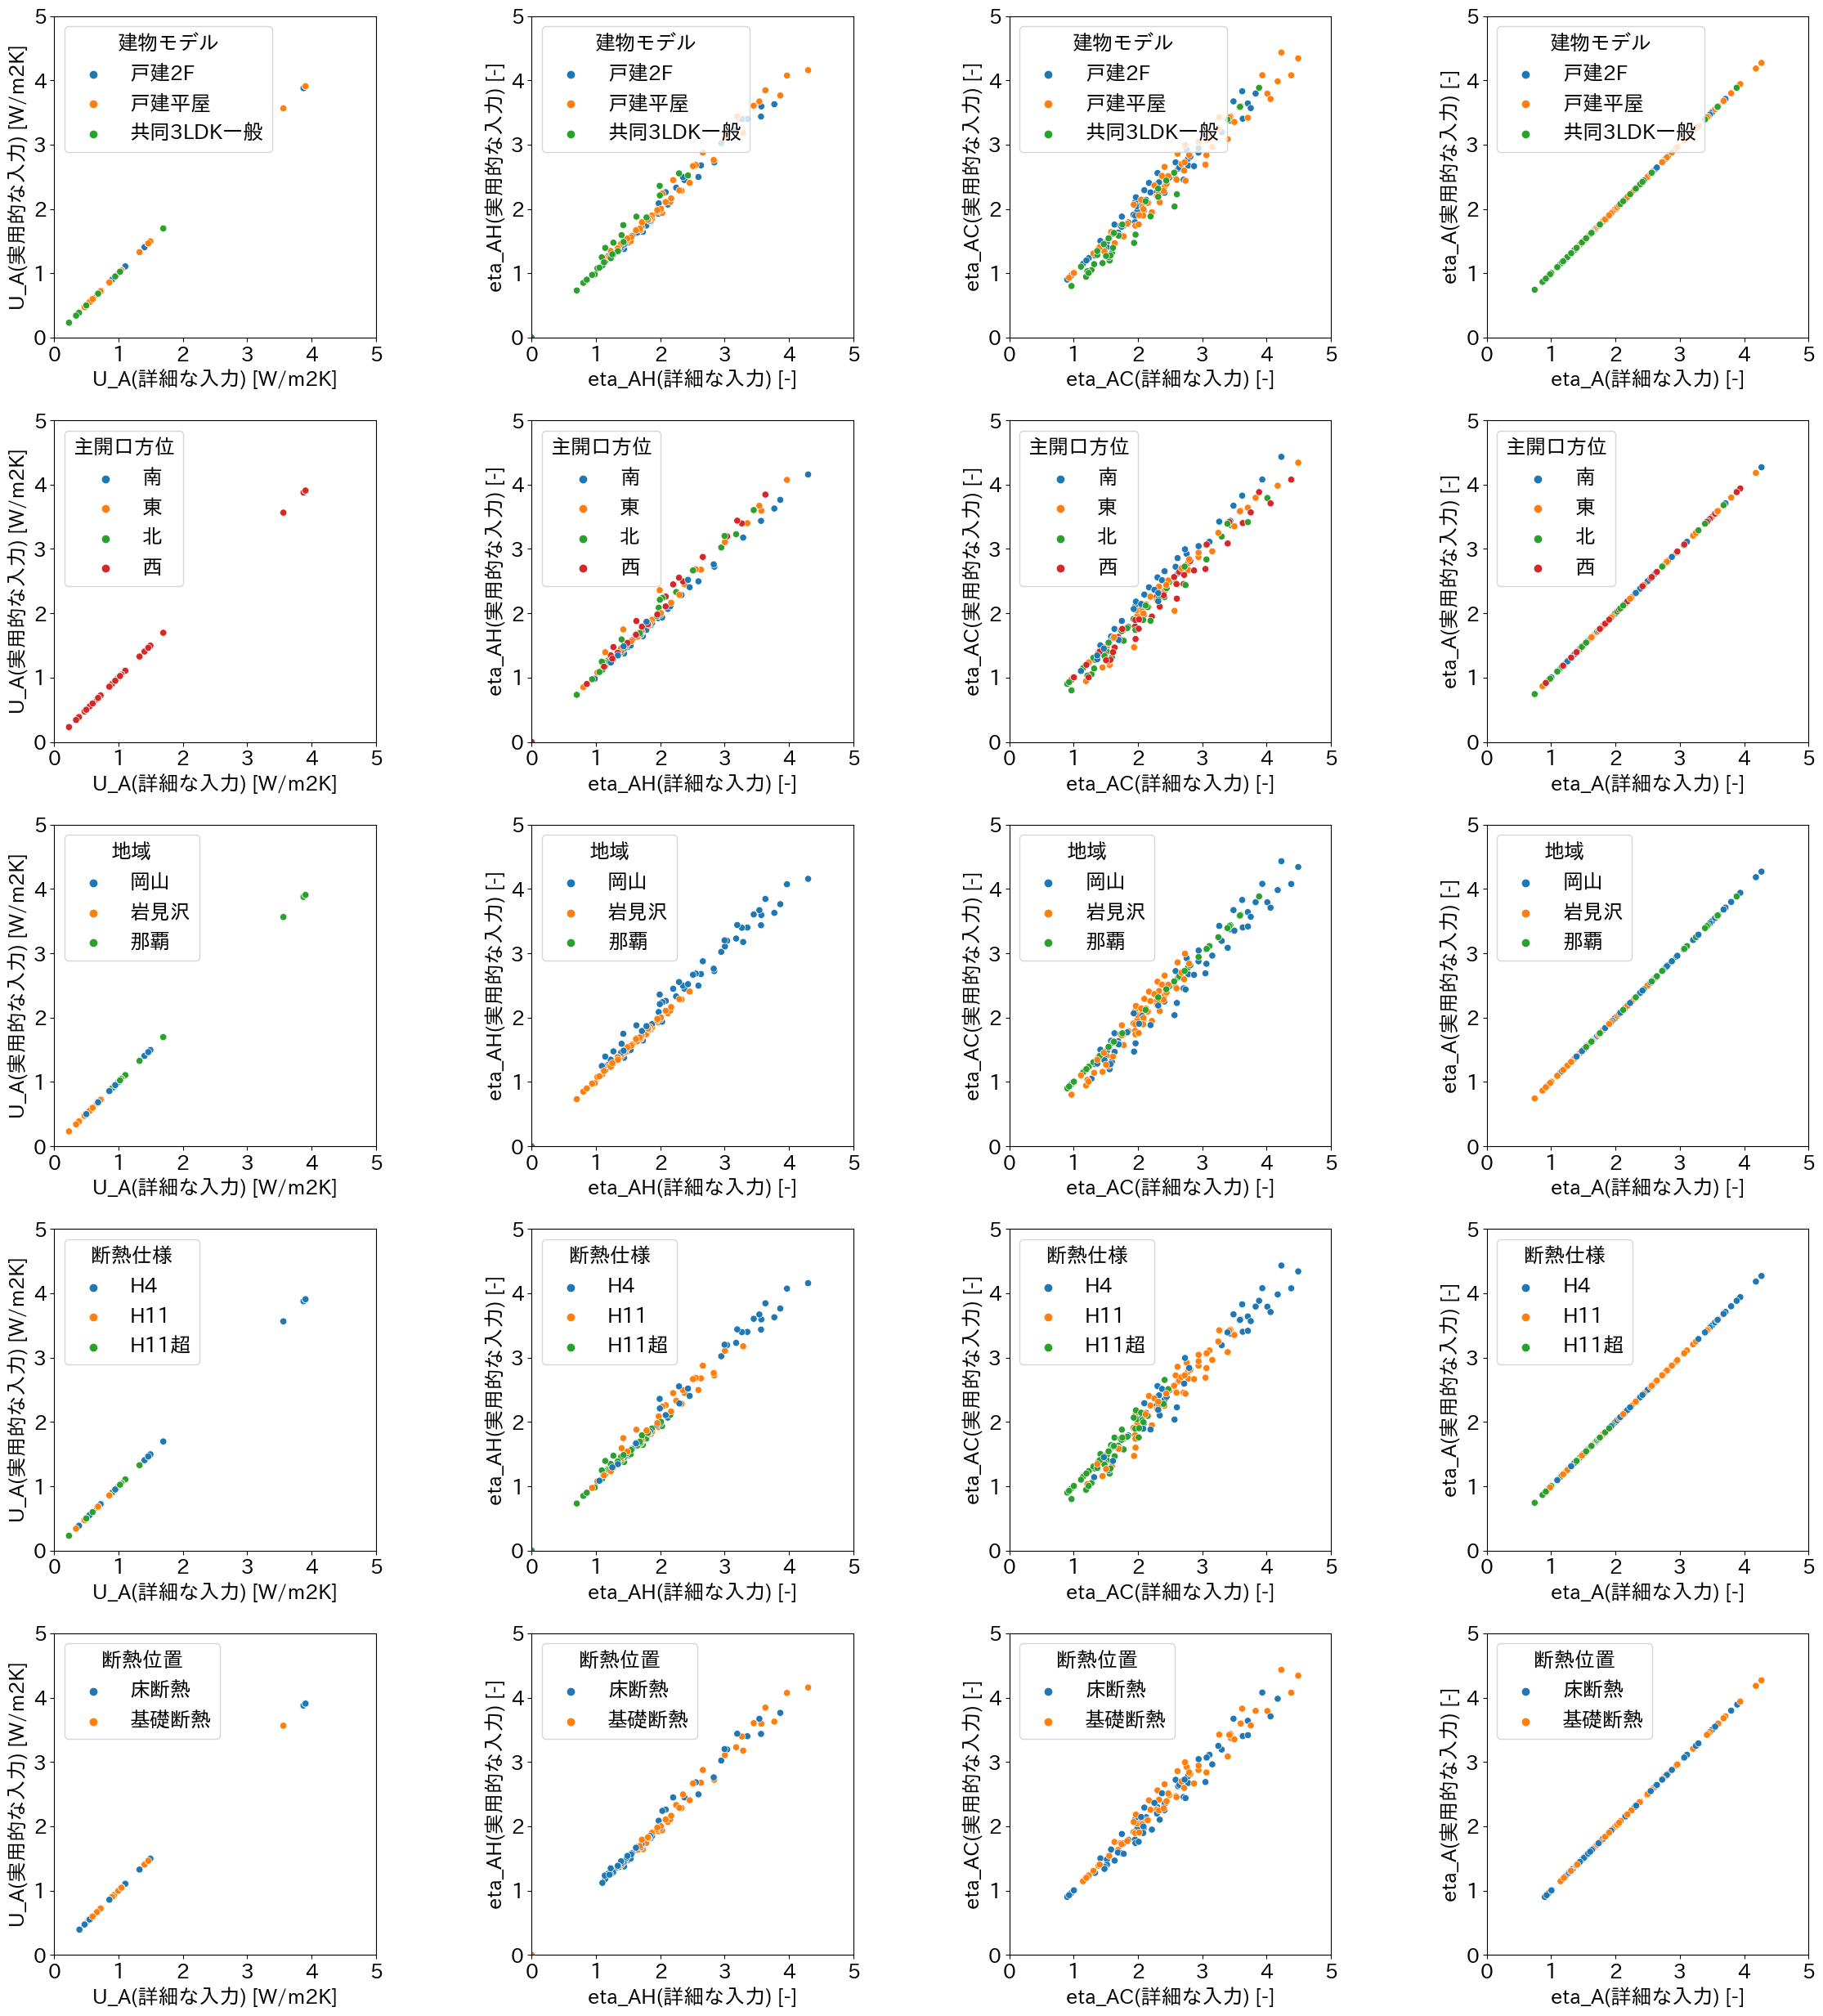

In [12]:
hues = ['建物モデル', '主開口方位', '地域', '断熱仕様', '断熱位置']
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(24, 25))
for ax, hue in zip(axes, hues):
    # 断熱位置で色分けする場合は、共同住宅の計算結果はプロットしないものとする。
    if hue == '断熱位置':
        df = heat_load_df[heat_load_df['建物モデル'] != '共同3LDK一般']
    else:
        df = heat_load_df

    sns.scatterplot(df, x='U_A(詳細な入力) [W/m2K]', y='U_A(実用的な入力) [W/m2K]', hue=hue, ax=ax[0])
    ax[0].set_xlim([0, 5.0])
    ax[0].set_ylim([0, 5.0])
    ax[0].set_aspect('equal')

    sns.scatterplot(df, x='eta_AH(詳細な入力) [-]', y='eta_AH(実用的な入力) [-]', hue=hue, ax=ax[1])
    ax[1].set_xlim([0, 5.0])
    ax[1].set_ylim([0, 5.0])
    ax[1].set_aspect('equal')

    sns.scatterplot(df, x='eta_AC(詳細な入力) [-]', y='eta_AC(実用的な入力) [-]', hue=hue, ax=ax[2])
    ax[2].set_xlim([0, 5.0])
    ax[2].set_ylim([0, 5.0])
    ax[2].set_aspect('equal')

    sns.scatterplot(df, x='eta_A(詳細な入力) [-]', y='eta_A(実用的な入力) [-]', hue=hue, ax=ax[3])
    ax[3].set_xlim([0, 5.0])
    ax[3].set_ylim([0, 5.0])
    ax[3].set_aspect('equal')

plt.tight_layout()